# Reinforcement Learning on game
Algorithms under Resource Constraints: A Case
Study on** SpaceInvaders **

# Firstmodel is Deep Q-Networks (DQN), which is based on Markov decison and normaly used in the Reinforcement Learning, and need to use the gymnasim and stable-baseline3.reference:https://stable-baselines3.readthedocs.io/en/master/guide/rl.html

# 1. set up the environment

In [ ]:
#first need to install the pacakge and evn, thanks to colab, i failed so many times on my own gpu because it is a relatively outdated package.
!pip install gymnasium[atari] stable-baselines3 ale-py==0.8.1 autorom
!AutoROM --accept-license

import gymnasium as gym
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
import base64
from IPython.display import HTML, display
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import EvalCallback

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


GrayScaleObservation Its function is to convert the observed values of color images into grayscale images. This is very useful in the reinforcement learning task of processing visual input, because grayscale images can reduce the amount of computation and model complexity, while retaining most of the useful information. Gray image is composed of a single channel, while color image usually has three channels (red, green, blue).

In [ ]:
# greyscale warpper
class GrayScaleObservation(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(0, 255, shape=(obs_shape[0], obs_shape[1], 1), dtype=np.uint8)

    def observation(self, observation):
        gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        return np.expand_dims(gray, -1)


In [ ]:
#create a canva
def make_env():
    env = gym.make("SpaceInvadersNoFrameskip-v4", render_mode='rgb_array')
    env = GrayScaleObservation(env)
    return env

# create training ev
train_env = DummyVecEnv([make_env])
train_env = VecFrameStack(train_env, n_stack=2)

# create evaluation ev
eval_env = DummyVecEnv([make_env])
eval_env = VecFrameStack(eval_env, n_stack=2)

# EvalCallback：every 5000 step evaluate once and saved the best model
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./best_model",
    log_path="./eval_logs/",
    eval_freq=5000,
    deterministic=True,
    render=False
)


In [ ]:
#so i improved version of DQN
model = DQN(
    "CnnPolicy",
    train_env,
    buffer_size=10000,  # try to decrease the buffer size
    learning_starts=2000,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.2,  # increase the exploration
    exploration_final_eps=0.01,
    verbose=1,
    learning_rate=5e-4,  # increase the learn rate from
)

# train 50000 step（to adapt Colab）
model.learn(total_timesteps=50000, callback=eval_callback)
model.save("dqn_final")

Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7cf57cdc7790> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x7cf4df209510>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=135.00 +/- 0.00
Episode length: 1693.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1.69e+03 |
|    mean_reward      | 135      |
| rollout/            |          |
|    exploration_rate | 0.505    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.000149 |
|    n_updates        | 749      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.217    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 229      |
|    time_elapsed     | 34       |
|    total_timesteps  | 7906     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.452    |
|    n_updates        | 1476     |
--------------

In [1]:
def show_frame(img):
    clear_output(wait=True)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
# get best model and record one video
model = DQN.load("./best_model/best_model")
obs = eval_env.reset()
episode_reward = 0
frames = []

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    episode_reward += reward

    frame = eval_env.render(mode="rgb_array")
    frames.append(frame)

    if done[0]:
        print(f"Episode Reward: {episode_reward}")
        break


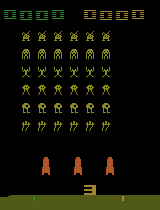

In [ ]:
# saved as gif
imageio.mimsave("episode.gif", frames, fps=30)

# show gif
with open("episode.gif", "rb") as f:
    data = f.read()
    data_url = base64.b64encode(data).decode("utf-8")
    display(HTML(f'<img src="data:image/gif;base64,{data_url}" />'))



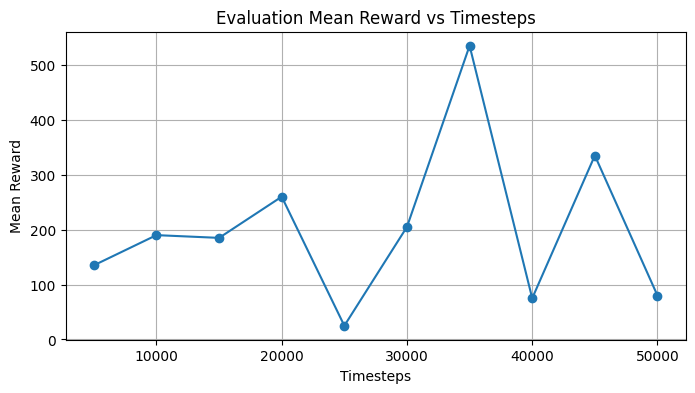

In [ ]:
# draw reward curve
import os
log_file = os.path.join("./eval_logs", "evaluations.npz")
if os.path.exists(log_file):
    data = np.load(log_file)
    timesteps = data["timesteps"]
    rewards = data["results"].mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(timesteps, rewards, marker="o")
    plt.title("Evaluation Mean Reward vs Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Reward")
    plt.grid(True)
    plt.savefig("reward_curve.png")
    plt.show()
else:
    print("No eval log found to plot.")

to be honest, in a limitation of 50,000 step, it did a good job.

# CnnPolicy + PPO
PPO also used by lots of people in the reinforement learning.so i want to have a try.

In [ ]:
from stable_baselines3 import PPO

In [ ]:
# model name
model_name = "ppo"

model = PPO(
    "CnnPolicy",
    train_env,
    learning_rate=1e-4,
    n_steps=256,
    batch_size=32,
    n_epochs=4,
    ent_coef=0.01,
    vf_coef=0.25,
    clip_range=0.2,
    normalize_advantage=True,
    verbose=1,
)


eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=f"./best_model_{model_name}",
    log_path=f"./eval_logs_{model_name}",
    eval_freq=5000,
    deterministic=True,
    render=False,
    n_eval_episodes=3  # same as last time
)


Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7cf57d0efbd0> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x7cf4df209510>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


----------------------------
| time/              |     |
|    fps             | 412 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 256 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 309           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00039630546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.79         |
|    explained_variance   | 0.664         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0269       |
|    n_updates            | 4             |
|    policy_gradient_loss | -0.00136      |
|    value_loss           | 0.0824        |
-------------------------------------------
-----

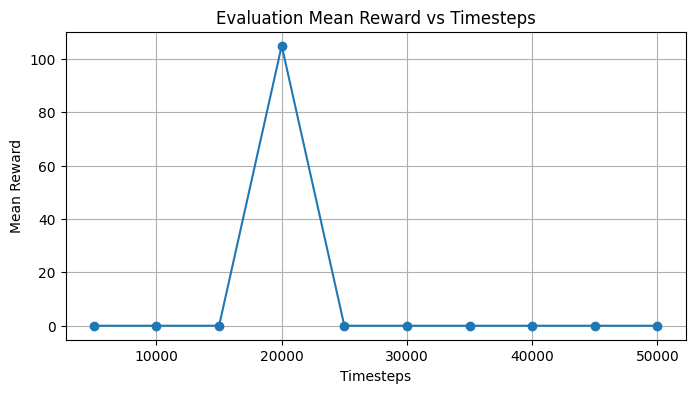


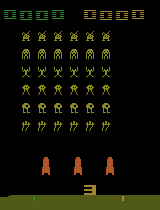

In [ ]:
# train for PPO
model.learn(total_timesteps=50000, callback=eval_callback)
model.save(f"ppo_final")

# draw reward curve
log_file = os.path.join(f"./eval_logs_{model_name}", "evaluations.npz")
if os.path.exists(log_file):
    data = np.load(log_file)
    timesteps = data["timesteps"]
    rewards = data["results"].mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(timesteps, rewards, marker="o")
    plt.title("Evaluation Mean Reward vs Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Reward")
    plt.grid(True)
    plt.savefig("reward_curve.png")
    plt.show()
else:
    print("No eval log found to plot.")

# load PPO best model and record 1 video
model = PPO.load(f"./best_model_{model_name}/best_model")
obs = eval_env.reset()
episode_reward = 0
frames = []

for _ in range(1500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    episode_reward += reward

    frame = eval_env.render(mode="rgb_array")
    frames.append(frame)

    if done[0]:
        print(f"Episode Reward: {episode_reward}")
        break

# saved as gif
imageio.mimsave("episode.gif", frames, fps=30)

# show gif
with open("episode.gif", "rb") as f:
    data = f.read()
    data_url = base64.b64encode(data).decode("utf-8")
    display(HTML(f'<img src="data:image/gif;base64,{data_url}" />'))


not as good as DQN, because it needs advanced setup and hardware, and 50,000 step for reinforement learning is not enough, however, due to the colab limitation, we must do it.

# QR-DQN（Quantile Regression DQN）
A distributional variant of DQN predicting quantiles of return distributions

In [ ]:
!pip install sb3-contrib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
from sb3_contrib import QRDQN

model_name = "QRDQN"
model = QRDQN(
    "CnnPolicy",
    train_env,
    buffer_size=20_000,
    learning_starts=5_000,
    train_freq=4,
    target_update_interval=1000,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    verbose=1,
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=f"./best_model_{model_name}",
    log_path=f"./eval_logs_{model_name}",
    eval_freq=5000,
    deterministic=True,
    render=False,
    n_eval_episodes=3  # same as other
)


Using cuda device
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x7ac0a66ff310> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x7ac16e3da610>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=5000, episode_reward=270.00 +/- 0.00
Episode length: 2151.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 2.15e+03 |
|    mean_reward      | 270      |
| rollout/            |          |
|    exploration_rate | 0.0102   |
| time/               |          |
|    total_timesteps  | 5000     |
----------------------------------
New best mean reward!
Eval num_timesteps=10000, episode_reward=5.00 +/- 0.00
Episode length: 1175.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1.18e+03 |
|    mean_reward      | 5        |
| rollout/            |          |
|    exploration_rate | 0.01     |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 0.3      |
|    n_updates        | 1249     |
----------------------------------
-------------------------------

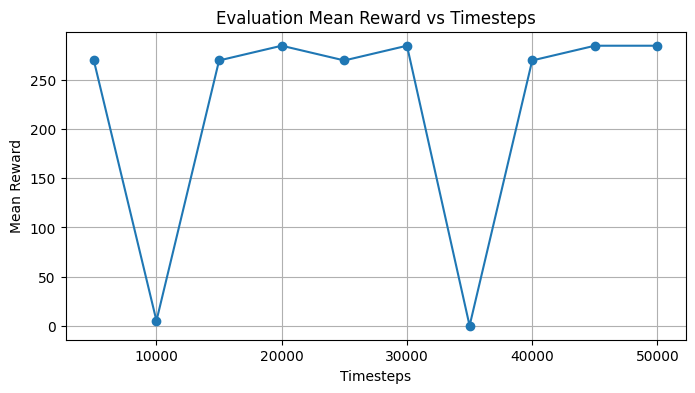

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(



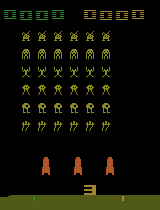

In [ ]:
# draw reward curve
model.learn(total_timesteps=50000, callback=eval_callback)
model.save(f"qrdqn_final")
import os
log_file = os.path.join(f"./eval_logs_{model_name}", "evaluations.npz")
if os.path.exists(log_file):
    data = np.load(log_file)
    timesteps = data["timesteps"]
    rewards = data["results"].mean(axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(timesteps, rewards, marker="o")
    plt.title("Evaluation Mean Reward vs Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Reward")
    plt.grid(True)
    plt.savefig("reward_curve.png")
    plt.show()
else:
    print("No eval log found to plot.")

# load QR-DQN best model and record 1 video
model = QRDQN.load(f"./best_model_{model_name}/best_model")
obs = eval_env.reset()
episode_reward = 0
frames = []

for _ in range(1500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = eval_env.step(action)
    episode_reward += reward

    frame = eval_env.render(mode="rgb_array")
    frames.append(frame)

    if done[0]:
        print(f"Episode Reward: {episode_reward}")
        break

# saved as gif
imageio.mimsave("episode.gif", frames, fps=30)

# show gif
with open("episode.gif", "rb") as f:
    data = f.read()
    data_url = base64.b64encode(data).decode("utf-8")
    display(HTML(f'<img src="data:image/gif;base64,{data_url}" />'))

QR-DQN better than PPO but worse than DQN